주택 가격을 어떻게 예측할까?  
> 학습 데이터 각각에 정답이 주어져 있으므로 <mark>지도학습</mark>이며, 주택가격을 연속된 값으로 예측하는 것이므로 <mark>회귀(regression)</mark> 문제이다  

Hypothesis(가설 = 모델) h 를 어떻게 만들면 좋을까?
> $h_\theta(x) = \theta_0 + \theta_1x$  

> 입력변수 x가 하나인 경우, 선형 회귀(Linear Regression) 문제는 <mark>주어진 학습데이터와 가장 잘 맞는 Hypothesis 함수 h를 찾는 문제</mark>가 됨  

> 데이터의 특징이 여러개가 존재해서 평면상의 방정식이 아니라 <mark>다차원</mark>에서 고민해야할 때가 많음  

학습률(Learning Rate)
> $\theta:=\theta-\alpha{ d\over dt}J_\theta(x)$ 

> 학습률이 작다면 최솟값을 찾으러 가는 간격이 작게 된다  
여러번 갱신해야 하지만 최솟값에 잘 도달할 수 있다  

> 학습률이 크다면 최솟값을 찾으러 가는 간격이 크게 된다  
만약 최솟값을 찾았다면 갱신 횟수는 상대적으로 적을 수 있으나 수렴하지 않고 진동할 수도 있음  

---

# 선형 회귀 실습 - Boston House Price

## 1. Boston 집값 예측 데이터 들여다보기

### 1) 데이터 읽어오기

In [1]:
from sklearn.datasets import load_boston

boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/Users/gahi/.pyenv/versions/dlex/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California

In [2]:
[each for each in boston.feature_names]

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

### 2) DATAFRAME 정리

In [3]:
import pandas as pd

boston_pd = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_pd['PRICE'] = boston.target

boston_pd.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 3) TARGET인 집값의 히스토그램 조사

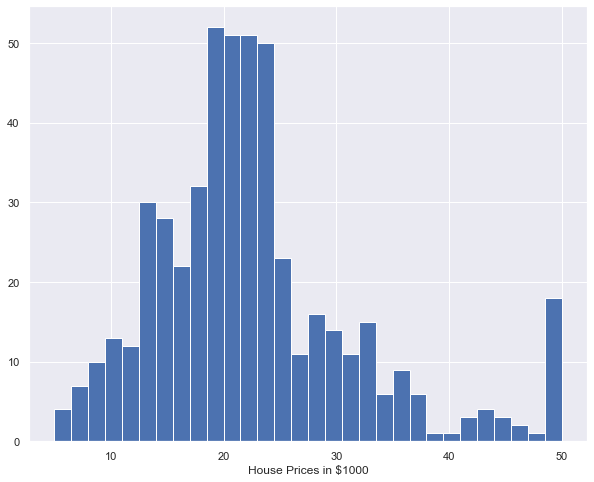

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize' : (10, 8)})
plt.hist(boston_pd['PRICE'], bins=30)
plt.xlabel('House Prices in $1000')
plt.show()

### 4) 상관관계 조사

<AxesSubplot:>

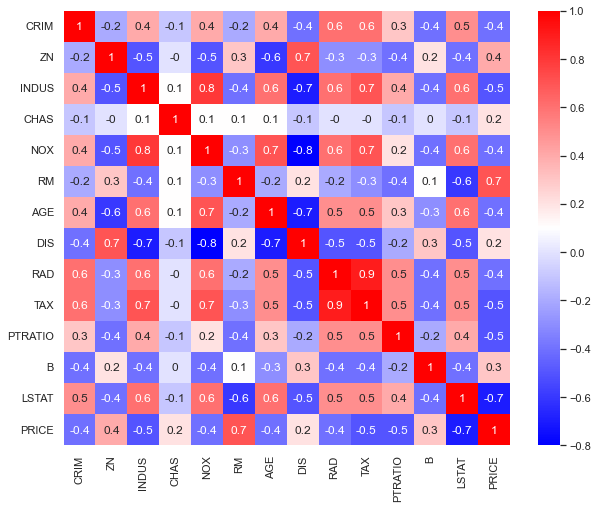

In [5]:
correlation_matrix = boston_pd.corr().round(1)
sns.heatmap(data = correlation_matrix, annot=True, cmap="bwr")

### 5) RM과 LSTAT VS PRICE에 대해 좀 더 들여다보기

<AxesSubplot:xlabel='LSTAT', ylabel='PRICE'>

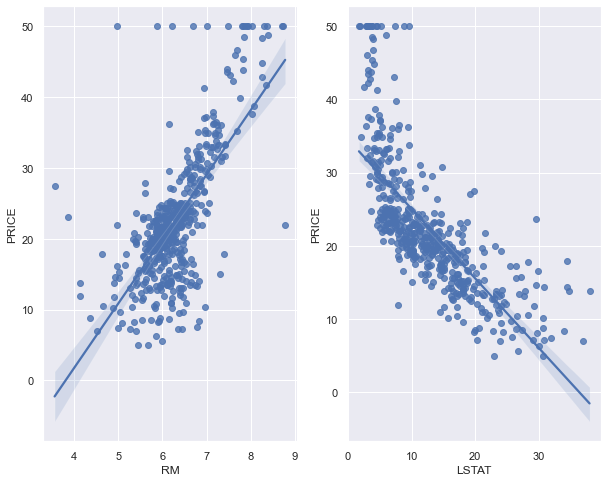

In [6]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols = 2)
sns.regplot(x='RM', y='PRICE', data=boston_pd, ax=axs[0])
sns.regplot(x='LSTAT', y='PRICE', data=boston_pd, ax=axs[1])

저소득층 인구가 낮을수록, 방 수가 많을 수록 >> 집 가격이 높아짐

## 2. 집 가격 예측을 위한 모델 구축 - (1) 방의 개수와 집 가격

### 1) 데이터 준비

In [7]:
import numpy as np

X_rooms = boston_pd['RM']
y_price = boston_pd['PRICE']

X_rooms = np.array(X_rooms).reshape(-1,1)

print(X_rooms.shape)
print(y_price.shape)

(506, 1)
(506,)


### 2) 학습용 데이터와 테스트용 데이터로 분리

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
                        train_test_split(X_rooms, y_price,
                                        test_size=0.2, 
                                        random_state=13)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(404, 1) (102, 1)
(404,) (102,)


### 3) 선형회귀 모델 학습

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### 4) 훈련용 데이터로 모델 평가 MEAN SQUARE ERROR 조사

In [10]:
from sklearn.metrics import mean_squared_error

y_train_predict = reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is ', rmse)

The model performance for training set
--------------------------------------
RMSE is  6.558400914980574


### 5) 테스트용 데이터로 모델 평가

In [11]:
y_test_predict = reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is ', rmse)

The model performance for training set
--------------------------------------
RMSE is  6.7881975443771765


### 6) 구축한 모델 그려보기

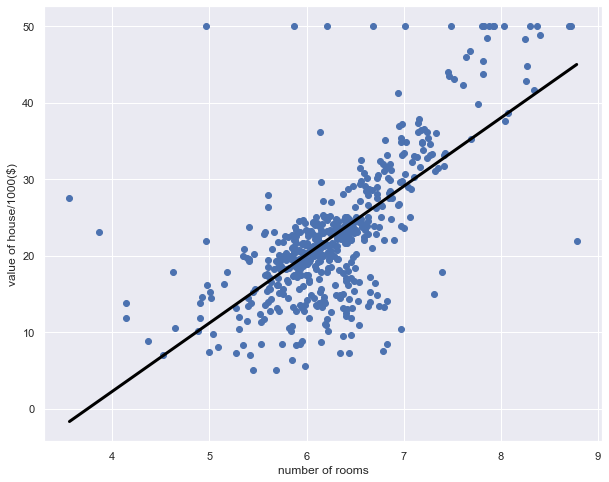

In [12]:
prediction_space = np.linspace(min(X_rooms), max(X_rooms)).reshape(-1, 1)

plt.scatter(X_rooms, y_price)
plt.plot(prediction_space, reg.predict(prediction_space),
        color = 'black', linewidth = 3)
plt.ylabel('value of house/1000($)')
plt.xlabel('number of rooms')
plt.show()

## 2. 집 가격 예측을 위한 모델 구축 - (2) 전체 특성 사용

### 1) 전체 특성을 사용해서 학습

In [13]:
X = boston_pd.drop('PRICE', axis = 1)
y = boston_pd['PRICE']

X_train, X_test, y_train, y_test = \
                        train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=13)

reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

LinearRegression()

### 2) 훈련용 데이터에 대한 성능

In [14]:
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is ', rmse)

The model performance for training set
--------------------------------------
RMSE is  4.642806069019824


### 3) 테스트용 데이터에 대한 성능

In [15]:
y_pred = reg_all.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is ', rmse)

The model performance for training set
--------------------------------------
RMSE is  4.9313525841467


### 4) 테스트용 데이터의 참값과 예측값을 그려서 확인

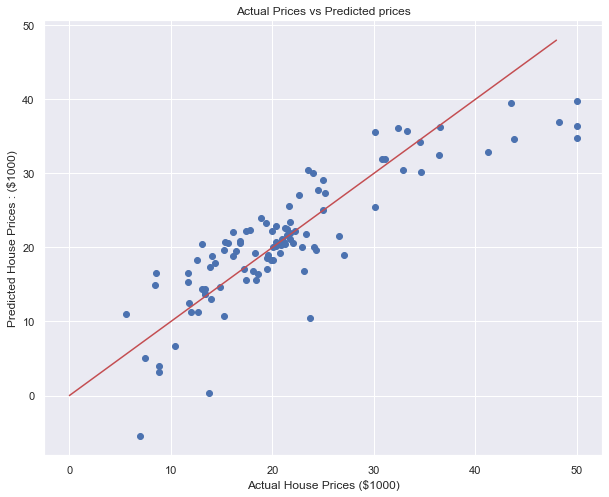

In [16]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual House Prices ($1000)')
plt.ylabel('Predicted House Prices : ($1000)')
plt.title('Actual Prices vs Predicted prices')
plt.plot([0, 48], [0, 48], 'r')